## Статистический анализ данных: сервис аренды самокатов

*Краткое описание:*
Имеются данные сервиса аренды самокатов о некоторых пользователях из нескольких городов, а также об их поездках. В проекте будет проанализирован ряд гипотез, которые помогут выстроить стратегию дальнейшего развития для бизнеса.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import math as m
from math import sqrt
from scipy.stats import binom, norm

#### Шаг 1. Загрузка данных

*Информация о данных в users_go*

In [2]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv')
except:
    users_go = pd.read_csv('https://.../.../users_go.csv')
    
users_go.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [3]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


*Информация о данных в rides_go*

In [4]:
try:
    rides_go = pd.read_csv('/datasets/rides_go.csv')
except:
    rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

rides_go.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


*Информация о данных в subscriptions_go*

In [6]:
try:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 2. Предобработка данных

В столбце date в дата фрейме rides_go заменим тип данных на datetime

In [7]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y%m%dT')
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавим в датафрейм новый столбец month, с информацией о месяце, в котором была поездка.

In [8]:
# за какие года данные
rides_go['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

In [9]:
rides_go['month'] = rides_go['date'].dt.month
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [10]:
# Проверка на наличие пропущенных значений в users_go
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Из данных выше видно, что в датафрейме users_go нет пропущенных значений.

In [11]:
# Проверка на наличие дубликатов в users_go
print('Найдено полных дубликатов в users_go:', users_go.duplicated().sum())

Найдено полных дубликатов в users_go: 31


In [12]:
users_go = users_go.drop_duplicates()
print('Найдено полных дубликатов в users_go:', users_go.duplicated().sum())

Найдено полных дубликатов в users_go: 0


In [13]:
# Проверка на наличие неявных дубликатов в users_go 
users_go['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Неявные дубликаты в users_go могли оказаться в названиях городов, однако выявлены не были.

In [14]:
# Проверка на наличие пропущенных значений в rides_go
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Исходя из данных выше, пропущенные значения в rides_go отсутствуют.

In [15]:
# Проверка на наличие дубликатов в rides_go
print('Найдено полных дубликатов в rides_go:', rides_go.duplicated().sum())

Найдено полных дубликатов в rides_go: 0


В датафрейме rides_go нет столбцов, где могли бы быть неявные дубликаты. Поэтому проверка на их наличие не требуется.

In [16]:
# Датафрейм subscriptions_go
subscriptions_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В датафрейме subscriptions_go  две строки, с данными о типе подписки. Пропуски и дубликаты в данном датафрейме отсутствуют.

**Вывод:**
- столбец date датафрейма users_go приведен к формату datetime.
- в датафрейм users_go добавлен новый столбец с месяцем (month).
- в users_go не было найдено пропущенных значений. При проверке в датафрейме было выявлено и сключено 31 полных дубликатов. Неявные дубликаты в данном датафрейме отсутствуют.
- в rides_go не были найдены пропущенные значения, дубликаты.
- в subscriptions_go не были найдены пропущенные значения, дубликаты.

In [18]:
rides_go['duration'].sort_values()

12013     0.500000
17314     0.500000
15029     0.500000
7437      0.500000
12967     0.500000
           ...    
6453     38.265229
1998     38.352763
2623     39.526602
4709     39.873856
4215     40.823963
Name: duration, Length: 18068, dtype: float64

In [19]:
rides_go[rides_go['duration'] < 2]['duration'].sort_values()

6531     0.5
14615    0.5
14574    0.5
14417    0.5
14342    0.5
        ... 
9581     0.5
9497     0.5
9282     0.5
10426    0.5
17909    0.5
Name: duration, Length: 95, dtype: float64

Есть аномально короткие заезды по 30 секунд.

In [20]:
# посмотрим на строки со значением 0.5 в столбце длительность
rides_go[rides_go['duration'] == 0.5]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Явно значения расстояния поездки не соответствуют времени в полминуты. Скорее всего техническая ошибка в данных. Поскольку таких строк достаточно мало (95 из 18068) их можно оставить в датафрейме.

#### Шаг 3. Исследовательский анализ данных

**3.1. Частота встречаемости городов**

Посмотрим на количество уникальных пользователей в каждом из городов. Для этого построим сводную таблицу, а затем отобразим данные на столбчатой диаграмме.

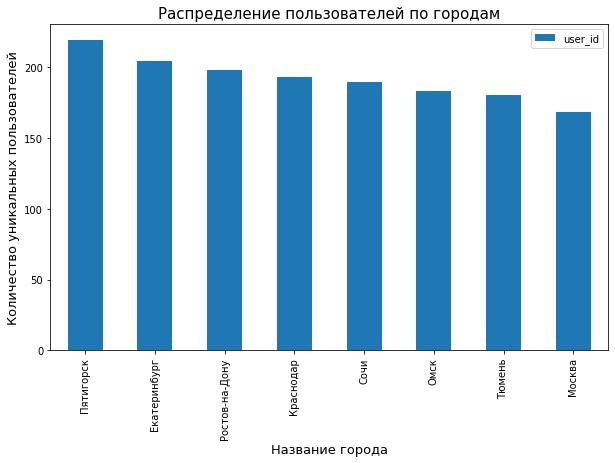

In [21]:
(users_go
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .reset_index()
 .sort_values('user_id', ascending=False)
 .plot(kind='bar', x='city', y='user_id', figsize=(10,6))
)
plt.title('Распределение пользователей по городам', size=15)
plt.xlabel('Название города', size=13)
plt.ylabel('Количество уникальных пользователей', size=13)
plt.show()

На диаграмме выше видно, что в датафрейме с уникальными пользователями наиболее часто встрячается город Пятигорск. Меньше всего уникальных пользователей в Москве (соответственно, частота встречаемости Москвы наименьшая среди всех городов).

In [22]:
frequency_city = (users_go
                  .pivot_table(index='city', values='user_id', aggfunc='count')
                  .reset_index() 
                  .sort_values('user_id', ascending=False))
frequency_city.columns = ['Город', 'Количество уникальных пользователей']
frequency_city

,Город,Количество уникальных пользователей
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


Объединим датафреймы rides_go и users_go по столбцу user_id:

In [23]:
rides_users_go = rides_go.merge(users_go, on='user_id')

Посмотрим на распределение количества поездок по городам:

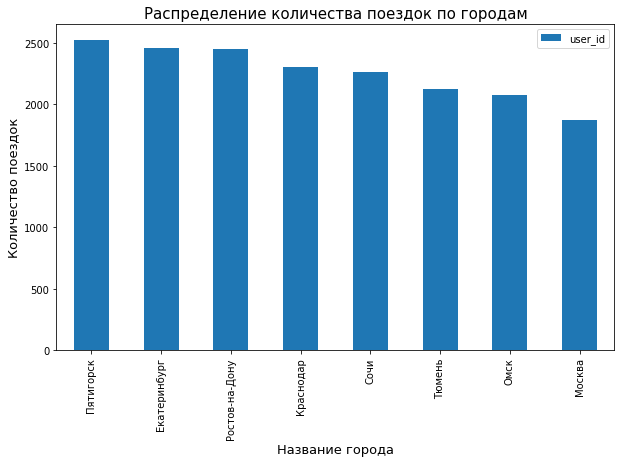

In [24]:
(rides_users_go
 .pivot_table(index='city', values='user_id', aggfunc='count')
 .reset_index()
 .sort_values('user_id', ascending=False)
 .plot(kind='bar', x='city', y='user_id', figsize=(10,6))
)
plt.title('Распределение количества поездок по городам', size=15)
plt.xlabel('Название города', size=13)
plt.ylabel('Количество поездок', size=13)
plt.show()

**3.2 соотношение пользователей с подпиской и без подписки**

In [25]:
users_sub = users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
print('Доля пользователей с подпиской ultra:', round(users_sub['user_id']['ultra']/users_sub['user_id'].sum()*100, 2), '%')

Доля пользователей с подпиской ultra: 45.57 %


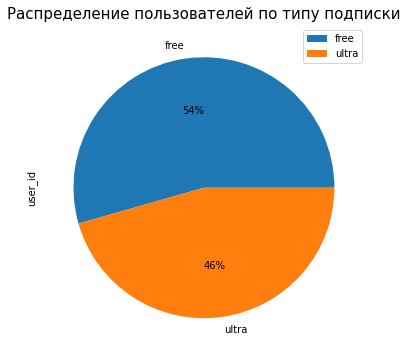

In [26]:
(users_sub
 .reset_index()
 .plot(kind='pie', x='subscription_type', y='user_id', figsize=(10,6), labels=users_sub.reset_index()['subscription_type'].unique(),  autopct = "%.0f%%",)
)

plt.title('Распределение пользователей по типу подписки', size=15)
plt.show()

**3.3 возраст пользователей**

In [28]:
print('Медианное значение для возраста пользователей:', users_go['age'].median())
print('Наиболее часто встречающееся значение возраста:', users_go['age'].mode()[0])

Медианное значение для возраста пользователей: 25.0
Наиболее часто встречающееся значение возраста: 25


В данных о возрасте пользователей мода и медиана равны.

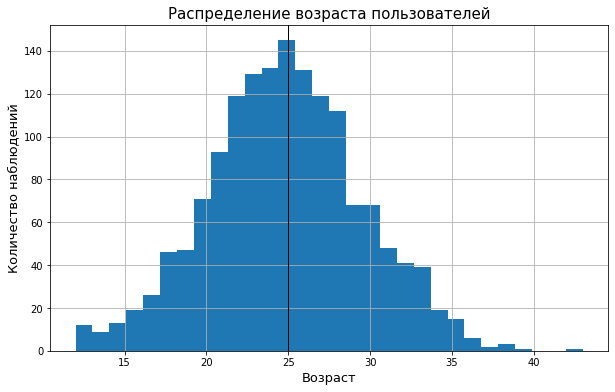

In [29]:
users_go['age'].hist(bins=30, figsize=(10,6))
plt.title('Распределение возраста пользователей', size=15)
plt.xlabel('Возраст', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.axvline(users_go['age'].median(), color='k', linestyle='-', linewidth=1)
plt.show()

Распределение похоже на нормальное.

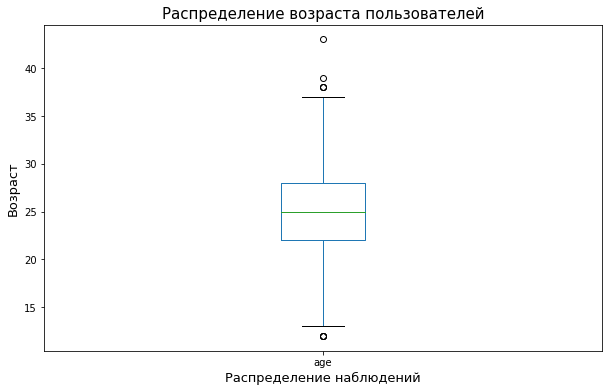

In [30]:
users_go['age'].plot(kind='box', figsize=(10,6))
plt.title('Распределение возраста пользователей', size=15)
plt.xlabel('Распределение наблюдений', size=13)
plt.ylabel('Возраст', size=13)
plt.show()

In [31]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Выше видно, что 75% пользователей находятся в возрасте от 22 до 28 лет (между 1 и 3 квартилем). 
Следует отметить, что среди пользователей некоторым менее 18 лет, именно с этого возраста разрешен прокат самокатов. В некоторых компаниях и регионах разрешено с 14 лет, но при письменном согласии родителей. В датасете минимальный возраст 12 лет, это явное нарушение существующих норм.

**3.4 расстояние, которое пользователь преодолел за одну поездку**

Построим график распределения среднего расстояния поездки для каждого пользователя.

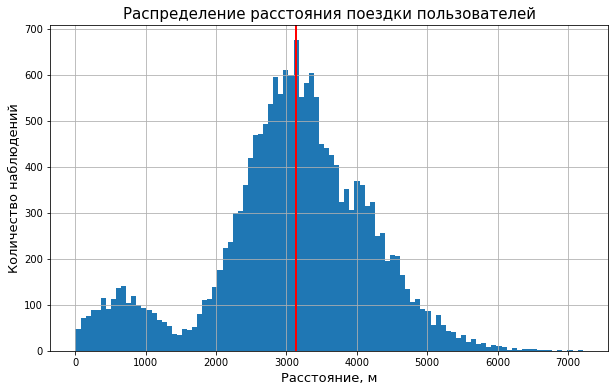

In [32]:
rides_go['distance'].hist(bins=100, figsize=(10,6))

plt.title('Распределение расстояния поездки пользователей', size=15)
plt.xlabel('Расстояние, м', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.axvline(rides_go['distance'].median(), color='r', linestyle='-', linewidth=2)
plt.show()

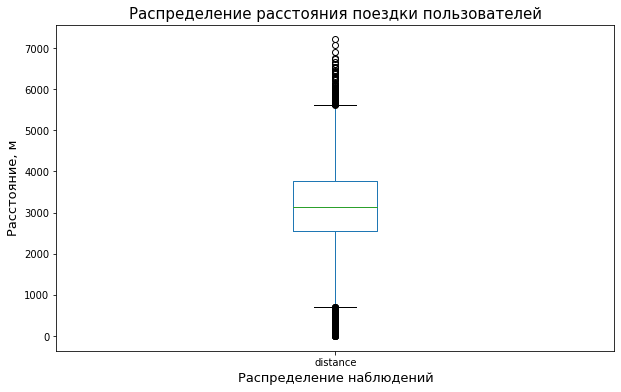

In [33]:
rides_go['distance'].plot(kind='box', figsize=(10,6))
plt.title('Распределение расстояния поездки пользователей', size=15)
plt.xlabel('Распределение наблюдений', size=13)
plt.ylabel('Расстояние, м', size=13)
plt.show()

In [34]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Исходя из данных выше, можно заметить следующее:
- в основном расстояние одной поездки от 2,5 до 3,7 км. 
- есть достаточно много выбросов снизу (и, соответственно, малый пик на гистограмме в поездках до 1км) - поездки на самокате действительно могут быть очень короткими.

**3.5 продолжительность поездок**

Сгруппируем данные о длительности поездки по пользователям и посмотрим на распределених значений.

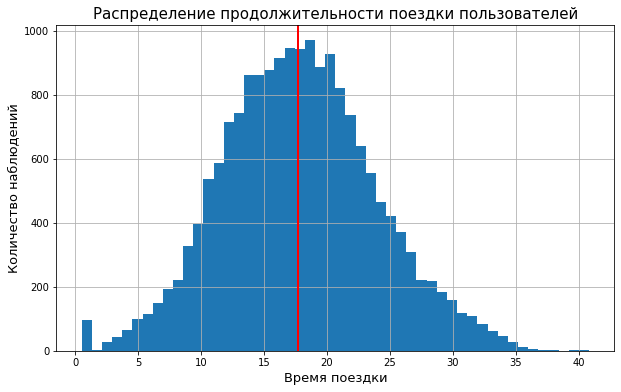

In [35]:
rides_go['duration'].hist(bins=50, figsize=(10,6))

plt.title('Распределение продолжительности поездки пользователей', size=15)
plt.xlabel('Время поездки', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.axvline(rides_go['duration'].median(), color='r', linestyle='-', linewidth=2)
plt.show()

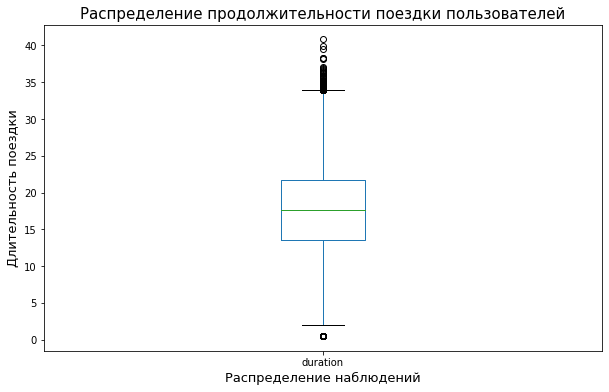

In [36]:
rides_go['duration'].plot(kind='box', figsize=(10,6))
plt.title('Распределение продолжительности поездки пользователей', size=15)
plt.xlabel('Распределение наблюдений', size=13)
plt.ylabel('Длительность поездки', size=13)
plt.show()

In [37]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Одна поездка в 75% случаев составляла от 13 до 22 минут (1 и 3 квартили).
Судя по минимальному значению, в данных есть аномалии - присутствуют поездки длительностью менее 1 минуты. Несмотря на такую низкую продолжительность, строки с аномально короткими поездками удалять не следует, так как в дальнейшем будет производится расчет выручки (можно потерять важные данный в других столбцах таких строк).

**Вывод:**
- В датафрейме с уникальными пользователями наиболее часто встрячается город Пятигорск. Меньше всего уникальных пользователей в Москве (соответственно, частота встречаемости Москвы наименьшая среди всех городов).
- Доля пользователей с подпиской ultra составляет 45.57% от общего количества наблюдений.
- Большинство пользователей (а именно 75%) находятся в возрасте от 22 до 28 лет. Наиболее частовстречающееся значение возраста пользователя (мода) - 25 лет.
- В основном средняя дальность поездки составляет от 2,5 км до 3,7 км (от 1 до 3 квартиля). Также в данных видно некоторое количество выбросов снизу диаграммы "ящика".
- Одна поездка в 75% случаев составляла от 13 до 22 минут (1 и 3 квартили)

#### Шаг 4. Объединение данных

**4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм.**

На шаге 3.1 были объединены датафреймы users_go и rides_go. Добавим к объединенным данным датафрейм subscription_go.

In [38]:
total_merged_go = rides_users_go.merge(subscriptions_go, on='subscription_type')
total_merged_go['distance'] = total_merged_go['distance']
total_merged_go.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [39]:
total_merged_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Пропуски отсутствуют. Размерность по строкам та же как в users_go.

**4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.**

Создадим два датафрейма, разделенных по типу подписки.

In [40]:
data_ultra = total_merged_go.query('subscription_type == "ultra"').reset_index(drop=True)
data_ultra

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [41]:
data_free = total_merged_go.query('subscription_type == "free"').reset_index(drop=True)
data_free

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
11564,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
11565,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
11566,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


**4.3 Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.**

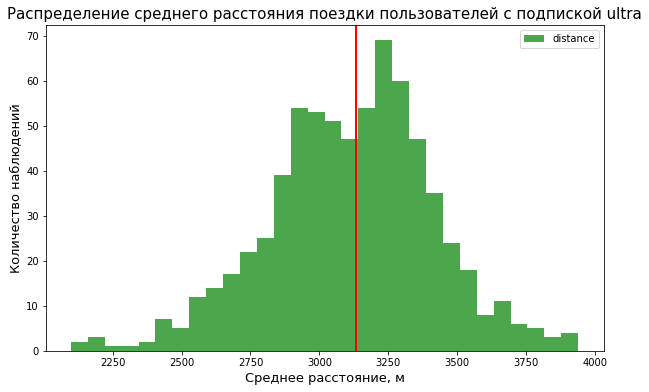

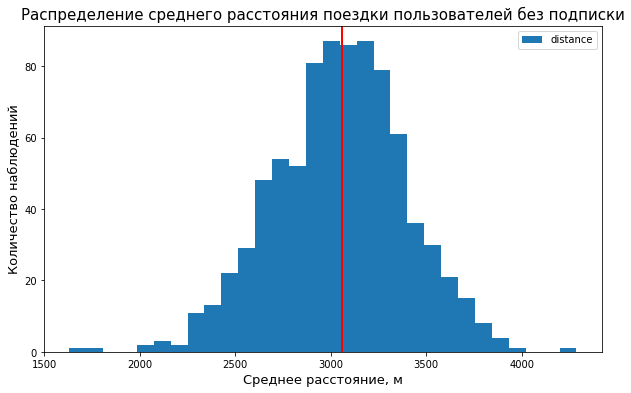

In [42]:
ultra_d_avg = data_ultra.pivot_table(index='user_id', values='distance')
free_d_avg = data_free.pivot_table(index='user_id', values='distance')

ultra_d_avg.plot(kind='hist', bins=30, figsize=(10,6), color='g', alpha=0.7, label='ultra_distance')
plt.axvline(ultra_d_avg['distance'].median(), color='r', linestyle='-', linewidth=2)
plt.title('Распределение среднего расстояния поездки пользователей с подпиской ultra', size=15)
plt.xlabel('Среднее расстояние, м', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.show()

free_d_avg.plot(kind='hist', bins=30, figsize=(10,6), label='free_distance')
plt.axvline(free_d_avg['distance'].median(), color='r', linestyle='-', linewidth=2)
plt.title('Распределение среднего расстояния поездки пользователей без подписки', size=15)
plt.xlabel('Среднее расстояние, м', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.show()


In [43]:
ultra_d_avg.describe() #информация по данным о пользователях с подпиской

,distance
count,699.000000
mean,3113.459926
std,299.706136
min,2098.297845
25%,2925.005435
50%,3134.349186
75%,3312.191643
max,3939.773328


In [44]:
free_d_avg.describe() #информация по данным о пользователях без подписки

,distance
count,835.000000
mean,3047.023441
std,346.570021
min,1630.788427
25%,2820.516763
50%,3057.940909
75%,3276.990199
max,4287.519387


Среднее расстояние одной поездки у пользователей с подпиской - от 2,9 до 3,3 км.
Среднее расстояние одной поездки у пользователей без подписки - от 2,8 до 3,2 км.
Значения среднего расстояния одной поездки у пользователей с разным типом подписки примерно одинаковое.

Теперь посмотрим на среднюю длительность одной поездки по пользователям с разным типом подписки.

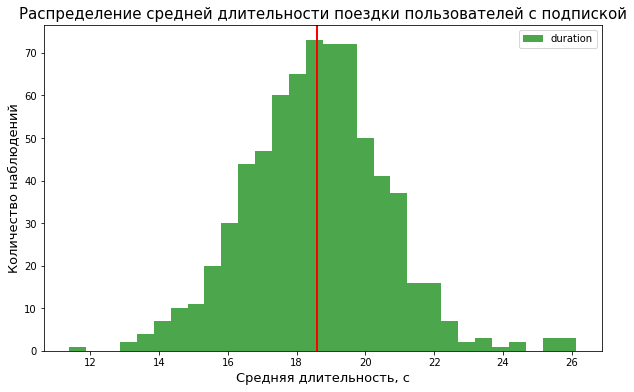

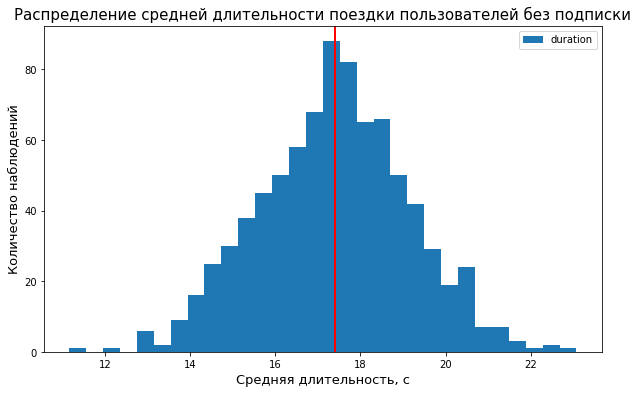

In [45]:
ultra_dur_avg = data_ultra.pivot_table(index='user_id', values='duration')
free_dur_avg = data_free.pivot_table(index='user_id', values='duration')

ultra_dur_avg.plot(kind='hist', bins=30, figsize=(10,6), color='g', alpha=0.7)
plt.axvline(ultra_dur_avg['duration'].median(), color='r', linestyle='-', linewidth=2)
plt.title('Распределение средней длительности поездки пользователей с подпиской', size=15)
plt.xlabel('Средняя длительность, с', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.show()

free_dur_avg.plot(kind='hist', bins=30, figsize=(10,6))
plt.axvline(free_dur_avg['duration'].median(), color='r', linestyle='-', linewidth=2)
plt.title('Распределение средней длительности поездки пользователей без подписки', size=15)
plt.xlabel('Средняя длительность, с', size=13)
plt.ylabel('Количество наблюдений', size=13)
plt.show()

In [46]:
ultra_dur_avg.describe() 

,duration
count,699.000000
mean,18.574380
std,2.015094
min,11.385922
25%,17.278630
50%,18.585189
75%,19.789236
max,26.136000


In [47]:
free_dur_avg.describe() 

,duration
count,835.000000
mean,17.384033
std,1.759845
min,11.163431
25%,16.209124
50%,17.402644
75%,18.568622
max,23.069943


Среднее время поездки пользователя с подпиской составляет от 17 до 20 минут. Среднее время поездки пользователя без подписки обычно варьируется от 16 до 19 минут. Разброс средней длительности у пользователей с подпиской чуть больше, чем у пользователей без подписки.

**Вывод:**
- Был сформирован общий датасет из трех первоначальных датафреймов.
- Были сформированы два датасета: с данными по пользователям с подпиской и с данными по пользователям без подписки.
- Среднее расстояние одной поездки у пользователей с подпиской - от 2,9 до 3,3 км. Среднее расстояние одной поездки у пользователей без подписки - от 2,8 до 3,2 км. Значения среднего расстояния одной поездки у пользователей с разным типом подписки примерно одинаковое.
- Среднее время поездки пользователя с подпиской составляет от 17 до 20 минут. Среднее время поездки пользователя без подписки обычно варьируется от 16 до 19 минут. Разброс средней длительности у пользователей с подпиской чуть больше, чем у пользователей без подписки.

#### Шаг 5. Подсчёт выручки

Из объединенного датафрейма в шаге 4, создадим таблицу с данными в разрезе суммарной длительности поездок, расстояния, количества поездок по каждому уникальному пользователи в каждый месяц (датафрейм tottal_agregated).

In [48]:
total_merged_go['duration'] = total_merged_go['duration'].apply(m.ceil)
total_merged_go.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [49]:
total_merged_go['distance'] = round(total_merged_go['distance'], 2)
total_agregated = total_merged_go.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum','count'])
total_agregated.columns = ['distance', 'duration', 'no_rides', 'delete']
total_agregated

distance  duration  no_rides  delete
user_id month                                      
1       1       7027.51        42         2       2
        4        754.16         7         1       1
        8       6723.47        46         2       2
        10      5809.91        32         2       2
        11      7003.50        56         3       3
...                 ...       ...       ...     ...
1534    6       3409.47        26         2       2
        8       7622.45        48         2       2
        9       4928.17        23         1       1
        11     13350.02        78         4       4
        12      2371.71        16         1       1

[11331 rows x 4 columns]

In [50]:
total_agregated = (total_agregated
                   .drop(columns='delete')
                   .reset_index()
                   .merge(users_go, on='user_id')
                   .merge(subscriptions_go, on='subscription_type')
                  )
total_agregated

,user_id,month,distance,duration,no_rides,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.51,42,2,Кира,22,Тюмень,ultra,6,0,199
1,1,4,754.16,7,1,Кира,22,Тюмень,ultra,6,0,199
2,1,8,6723.47,46,2,Кира,22,Тюмень,ultra,6,0,199
3,1,10,5809.91,32,2,Кира,22,Тюмень,ultra,6,0,199
4,1,11,7003.50,56,3,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,26,2,Альберт,25,Краснодар,free,8,50,0
11327,1534,8,7622.45,48,2,Альберт,25,Краснодар,free,8,50,0
11328,1534,9,4928.17,23,1,Альберт,25,Краснодар,free,8,50,0
11329,1534,11,13350.02,78,4,Альберт,25,Краснодар,free,8,50,0


In [51]:
total_agregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11331 entries, 0 to 11330
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   month              11331 non-null  int64  
 2   distance           11331 non-null  float64
 3   duration           11331 non-null  int64  
 4   no_rides           11331 non-null  int64  
 5   name               11331 non-null  object 
 6   age                11331 non-null  int64  
 7   city               11331 non-null  object 
 8   subscription_type  11331 non-null  object 
 9   minute_price       11331 non-null  int64  
 10  start_ride_price   11331 non-null  int64  
 11  subscription_fee   11331 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 1.1+ MB


пропусков нет.

In [52]:
total_agregated['revenue'] = total_agregated['duration']*total_agregated['minute_price'] +\
total_agregated['start_ride_price']*total_agregated['no_rides'] + total_agregated['subscription_fee']
total_agregated.head()

,user_id,month,distance,duration,no_rides,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.51,42,2,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,754.16,7,1,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,6723.47,46,2,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,5809.91,32,2,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,7003.50,56,3,Кира,22,Тюмень,ultra,6,0,199,535


Мы получили датафрейм с данными о суммарных длительности и дальности поездок для каждого пользователя в разрезе месяцев. Также добавлено количество поездок по пользователям в разрезе месяцев. В столбце revenue указана выручка в разрезе месяцев по каждому пользователю.

In [53]:
# Комментарий ревьюера
# Контроль суммы выручки
tmp, col_rev = total_agregated.copy(), 'revenue'
print("Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице:", tmp[col_rev].sum())

Правильное значение суммы выручки 3878641, сумма выручки расчитанная в таблице: 3878641


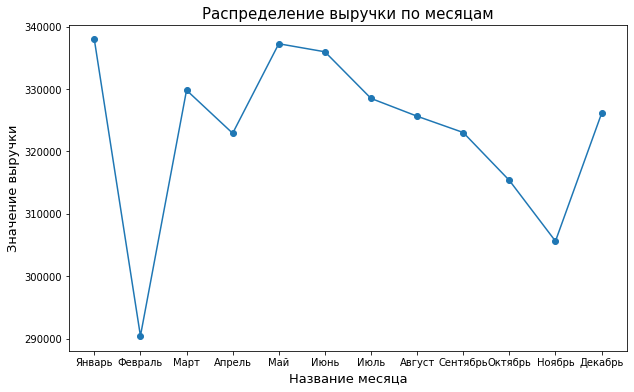

In [54]:
total_agregated.groupby('month')['revenue'].sum().plot(style='o-', x='month', y='revenue', figsize=(10, 6))
plt.title('Распределение выручки по месяцам', size=15)
plt.xlabel('Название месяца', size=13)
plt.ylabel('Значение выручки', size=13)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], \
           ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь'])
plt.show()

Наибольшая выручка наблюдается в январе и мае. Наименьшая выручка была получена в феврале.

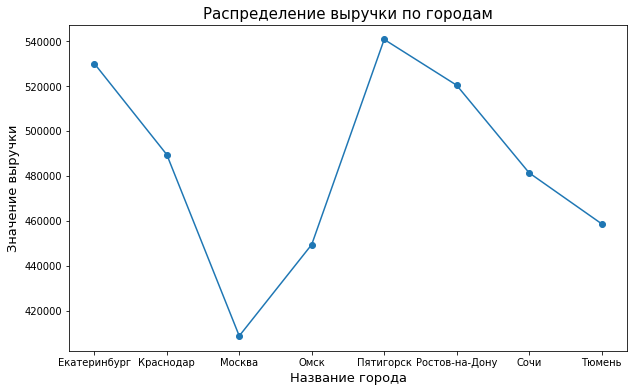

In [55]:
total_agregated.groupby('city')['revenue'].sum().plot(style='o-', x='city', y='revenue', figsize=(10, 6))
plt.title('Распределение выручки по городам', size=15)
plt.xlabel('Название города', size=13)
plt.ylabel('Значение выручки', size=13)
plt.show()

Наибольшая выручка была получена в Екатеринбурге и Пятигорске. Наименьшее значение выручки наблюдается в Москве.

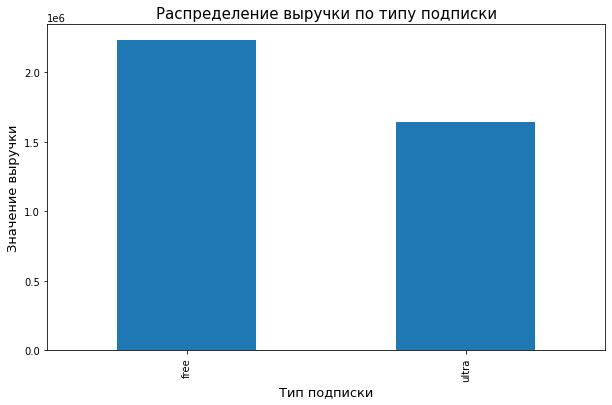

In [56]:
total_agregated.groupby('subscription_type')['revenue'].sum().plot(kind='bar', x='subscription_type',\
                                                                   y='revenue',figsize=(10, 6))
plt.title('Распределение выручки по типу подписки', size=15)
plt.xlabel('Тип подписки', size=13)
plt.ylabel('Значение выручки', size=13)
plt.show()

В имеющихся данных пользователи с подпиской сгенерировали практически такую же выручку, как пользователи без подписки.

**Вывод:**
- Создан новый датафрейм с данными о суммарных длительности и дальности поездок для каждого пользователя в разрезе месяцев. Также добавлено количество поездок по пользователям в разрезе месяцев. В столбце revenue указана выручка в разрезе месяцев по каждому пользователю.
- Детали о выручке: Наибольшая выручка наблюдается в январе и мае. Наименьшая выручка была получена в феврале; Наибольшая выручка была получена в Екатеринбурге и Пятигорске. Наименьшее значение выручки наблюдается в Москве; доля в выручке пользователей с подпиской и пользователей без подписки практически одинаковая. 

#### Шаг 6. Проверка гипотез

**6.1 Тратят ли пользователи с подпиской больше времени на поездки?**

Рассмотрим гипотезы:

Н0 - средняя продолжительность сессии пользователя с подпиской **равна** средней продолжительности сессии пользователя без пописки;

Н1 - средняя продолжительность сессии пользователя с подпиской **больше** средней продолжительности сессии пользователя без пописки (альтернативная гипотеза, одностороняя);

In [57]:
alpha = 0.05 #уровень значимости примем за 5%

#датафрейм rides_users_go объединяет данные датафреймов rides_go и users_go
result_1 = st.ttest_ind(rides_users_go[rides_users_go['subscription_type']=='ultra']['duration'], \
            rides_users_go[rides_users_go['subscription_type']=='free']['duration'], alternative='greater')

print('Значение p-value:', result_1.pvalue)
if result_1.pvalue < alpha:
    print('Гипотеза Н0 отвергается')
else:
    print('Гипотеза Н0 не отвергается')

Значение p-value: 1.2804098316645618e-34
Гипотеза Н0 отвергается


Пользователи с подпиской имеют бОльшую среднюю длительность поездки, а значит могу быть "выгоднее" компании.

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Рассмотрим гипотезы:

Н0 - среднее расстояние пользователя с подпиской **равно** 3130 метров;

Н1 - среднее расстояние пользователя с подпиской **больше** 3130 метров (альтернативная гипотеза, односторонняя);

In [58]:
alpha = 0.05 #уровень значимости примем за 5%

result_2 = st.ttest_1samp(rides_users_go[rides_users_go['subscription_type']=='ultra']['distance'], 3130, alternative='greater')

print('Значение p-value:', result_2.pvalue)
if result_2.pvalue < alpha:
    print('Гипотеза Н0 отвергается')
else:
    print('Гипотеза Н0 не отвергается')

Значение p-value: 0.9195368847849785
Гипотеза Н0 не отвергается


При 5-процентном уровне значимости гипотеза о среднем расстоянии одной поездки пользователя с подпиской в 3130 метров не отвергается. Соответственно, можно говорить о том, что данное значение не превышает 3130 метров.

**6.3 Проверка гипотезы о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.** 

Рассмотрим гипотезы:

Н0 - помесячная выручка от пользователей с подпиской **равна** выручке от пользователей без подписки;

Н1 - помесячная выручка от пользователей с подпиской **больше** выручки от пользователей без подписки (альтернативная гипотеза, односторонняя);

In [59]:
alpha = 0.05 #уровень значимости примем за 5%

result_3 = st.ttest_ind(total_agregated[total_agregated['subscription_type']=='ultra']['revenue'], \
                        total_agregated[total_agregated['subscription_type']=='free']['revenue'], alternative='greater')

print('Значение p-value:', result_3.pvalue)
if result_3.pvalue < alpha:
    print('Гипотеза Н0 отвергается')
else:
    print('Гипотеза Н0 не отвергается')

Значение p-value: 1.8850394384715216e-31
Гипотеза Н0 отвергается


Гипотеза о том, что помесячная выручка от пользователей с подпиской будет выше, чем выручка от пользователей без подписки подтвердилась.

**6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

**Ответ:**
В такой ситуации нужно использовать тест для проверки гипотезы о равенстве средних для зависимых (парных) выборок. Гипотезы в таком случае выглядят следующим образом:

Н0: mu1 = mu2

H1: mu1 > mu2 

mu1 - среднее генеральной совокупности до обновления сервера, mu2 - среднее генеральной совокупности после обновления сервера.

In [60]:
# код
# st.ttest_rel()

**Вывод:**
- в среднем пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- гипотеза о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров не подтвердилась.
- Гипотеза о том, что помесячная выручка от пользователей с подпиской будет выше, чем выручка от пользователей без подписки подтвердилась.

#### Шаг 7. Распределения

**7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.**


**Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.**

Эксперимент - пользователь получает месяц бесплатной подписки.


Исходы:

1. После окончания бесплатного периода пользователь продлевает подписку.
2. После окончания бесплатного периода пользователь не продлевает подписку.

Такое распределение биноминальное.

Попробуем оценить с помощью графиков, какая должна быть n - кол-во промокодов, чтобы вероятнее получить 100 успехов.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


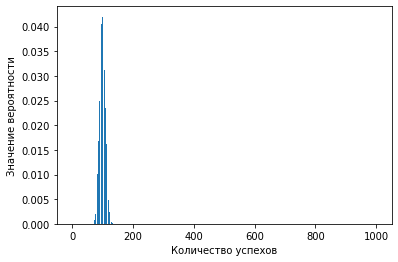

In [61]:
p = 0.1 # процент, продливших подписку после бесплатного периода
n = 1000 # количество промокодов (предположение)

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.xlabel('Количество успехов')
plt.ylabel('Значение вероятности')
plt.show()

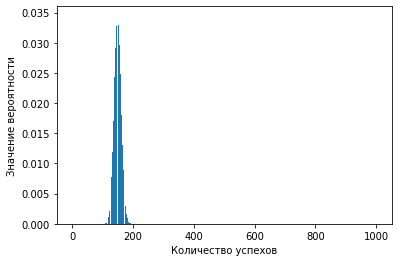

In [62]:
n_1 = 1500

distr_1 = []

for k in range(0, n + 1):
    current_value_1 = binom.pmf(k, n_1, p)
    distr_1.append(current_value_1)
    
plt.bar(range(0, n + 1), distr_1)
plt.xlabel('Количество успехов')
plt.ylabel('Значение вероятности')
plt.show()

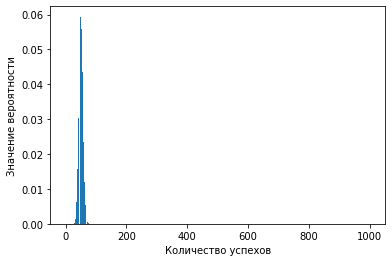

In [63]:
n_2 = 500

distr_2 = []

for k in range(0, n + 1):
    current_value_2 = binom.pmf(k, n_2, p)
    distr_2.append(current_value_2)
    
plt.bar(range(0, n + 1), distr_2)
plt.xlabel('Количество успехов')
plt.ylabel('Значение вероятности')
plt.show()

Исходя из графиков выше видно, что при n = 1000 наиболее вероятно получить около 100 успехов.

Проверим n = 1000 для выполнения плана (вероятность не выполнения плана 5%, следовательно, вероятность выполнения 100 - 5 = 95%).

In [64]:
k = 100 # минимальное количество успехов, необходимое для выполнения плана

prob = binom.cdf(k, n, p)
print('Вероятность не выполнить план при рассылке 1000 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1000 промокодов: 0.5266


Вероятность не выполнить план 52% - слишком много. 

При построении графика n = 1500, количество наиболее вероятных успехов сместилось к 200. Поэтому попробуем взять n от 1000 до 1500 и посмотреть на вероятность не выполнения плана.

In [65]:
prob = binom.cdf(k, 1100, p)
print('Вероятность не выполнить план при рассылке 1100 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1100 промокодов: 0.17009


In [66]:
prob = binom.cdf(k, 1150, p)
print('Вероятность не выполнить план при рассылке 1150 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1150 промокодов: 0.07494


In [67]:
prob = binom.cdf(k, 1160, p)
print('Вероятность не выполнить план при рассылке 1160 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1160 промокодов: 0.06234


In [68]:
prob = binom.cdf(k, 1170, p)
print('Вероятность не выполнить план при рассылке 1170 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1170 промокодов: 0.05151


In [69]:
prob = binom.cdf(k, 1171, p)
print('Вероятность не выполнить план при рассылке 1171 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1171 промокодов: 0.05052


In [70]:
prob = binom.cdf(k, 1172, p)
print('Вероятность не выполнить план при рассылке 1172 промокодов:', round(prob, 5))

Вероятность не выполнить план при рассылке 1172 промокодов: 0.04955


**Вывод:**

Методом подбора удалось подобрать такое значение n, при котором вероятность невыполнения плана равна примерно 5%.
Необходимо отправить 1172 промокода, чтобы с вероятностью 95% получить 100 человек, которые продлят свою подписку после бесплатного периода.

**7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.**

Эксперимент - пользователь получает push-уведомление.


Исходы:

1. После получения пользователь открыл уведомление.
2. После получения пользователь не открыл уведомление.

Такое распределение биноминальное.
Апроксимируем биноминальное распределение нормальным.

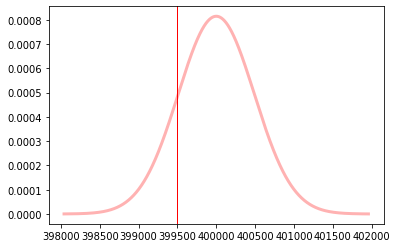

In [71]:
n = 1000000 # всего разосланных уведомлений 
p = 0.4 # вероятность открытия уведомления

# для визуализации
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

mu = n*p
sigma = sqrt(n*p*(1-p))

distr = st.norm(mu, sigma)

x = linspace(left, right, 2000000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3)
plt.axvline(399500, color='r', linestyle='-', linewidth=1)
plt.show()

In [72]:
prob = distr.cdf(399500)
print('Вероятность, что уведомление откроют не больше 399,5 тысяч пользователей:', round(prob, 4))

Вероятность, что уведомление откроют не больше 399,5 тысяч пользователей: 0.1537


**Вывод:**
С вероятностью 15,4% уведомление октроют не больше 399,5 тысяч пользователей

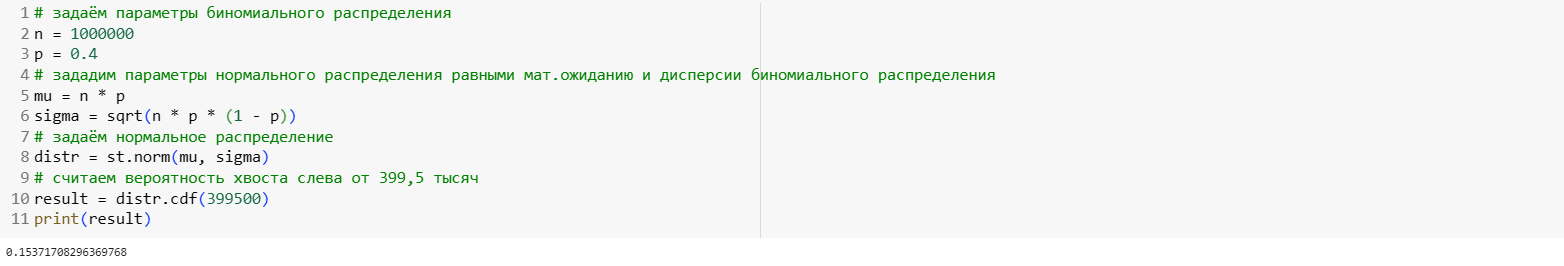

#### Итоги

*Предобработка данных:*
- столбец date датафрейма users_go приведен к формату datetime.
- в датафрейм users_go добавлен новый столбец с месяцем (month).
- в users_go не было найдено пропущенных значений. При проверке в датафрейме было выявлено и сключено 31 полных дубликатов. Неявные дубликаты в данном датафрейме отсутствуют.
- в rides_go не были найдены пропущенные значения, дубликаты.
- в subscriptions_go не были найдены пропущенные значения, дубликаты.

*Исследовательский анализ данных:*
- В датафрейме с уникальными пользователями наиболее часто встрячается город Пятигорск. Меньше всего уникальных пользователей в Москве (соответственно, частота встречаемости Москвы наименьшая среди всех городов).
- Доля пользователей с подпиской ultra составляет 45.57% от общего количества наблюдений.
- Большинство пользователей (а именно 75%) находятся в возрасте от 22 до 28 лет. Наиболее частовстречающееся значение возраста пользователя (мода) - 25 лет.
- В основном средняя дальность поездки составляет от 2,8 км до 3,3 км (от 1 до 3 квартиля). Также в данных видно некоторое количество выбросов снизу диаграммы "ящика".
- Средняя длительность поездки в 75% случаев составляла от 16 до 18 минут.

*Объединение данных:*
- Был сформирован общий датасет из трех первоначальных датафреймов.
- Были сформированы два датасета: с данными по пользователям с подпиской и с данными по пользователям без подписки.
- Среднее расстояние одной поездки у пользователей с подпиской - от 2,9 до 3,3 км. Среднее расстояние одной поездки у пользователей без подписки - от 2,8 до 3,2 км. Значения среднего расстояния одной поездки у пользователей с разным типом подписки примерно одинаковое.
- Среднее время поездки пользователя с подпиской составляет от 17 до 20 минут. Среднее время поездки пользователя без подписки обычно варьируется от 16 до 19 минут. Разброс средней длительности у пользователей с подпиской чуть больше, чем у пользователей без подписки.

*Подсчет выручки:*
- Создан новый датафрейм с данными о суммарных длительности и дальности поездок для каждого пользователя в разрезе месяцев. Также добавлено количество поездок по пользователям в разрезе месяцев. В столбце revenue указана выручка в разрезе месяцев по каждому пользователю.
- Детали о выручке: Наибольшая выручка наблюдается в январе и мае. Наименьшая выручка была получена в феврале; Наибольшая выручка была получена в Екатеринбурге и Пятигорске. Наименьшее значение выручки наблюдается в Москве; доля в выручке пользователей с подпиской и пользователей без подписки практически одинаковая.

*Проверка гипотез:*
- Первоначальная гипотеза подтвердилась. В среднем пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.
- Гипотеза о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров не подтвердилась.
- Гипотеза о том, что помесячная выручка от пользователей с подпиской будет выше, чем выручка от пользователей без подписки подтвердилась.